# modeling

In [1]:
import pandas as pd
import geopandas as gpd

## load data

In [2]:
train_test = gpd.read_file('../data/train_test.shp')

In [3]:
train_test.shape

(4325, 32)

In [4]:
train_test.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 4325 entries, 0 to 4324
Data columns (total 32 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   state       4325 non-null   object  
 1   district    4325 non-null   object  
 2   year        4325 non-null   object  
 3   month       4325 non-null   object  
 4   sss         4325 non-null   float64 
 5   sss_1m_l    4325 non-null   float64 
 6   sss_c_1m_l  4325 non-null   float64 
 7   sss_d_1m_l  4325 non-null   object  
 8   sss_2m_l    4325 non-null   float64 
 9   sss_c_2m_l  4325 non-null   float64 
 10  sss_d_2m_l  4325 non-null   object  
 11  chlora      4325 non-null   float64 
 12  chlora_1m_  4325 non-null   float64 
 13  chlora_c_1  4325 non-null   float64 
 14  chlora_d_1  4325 non-null   object  
 15  chlora_2m_  4325 non-null   float64 
 16  chlora_c_2  4325 non-null   float64 
 17  chlora_d_2  4325 non-null   object  
 18  lst         4325 non-null   float64 
 19

In [5]:
train_test.head()

,state,district,year,month,sss,sss_1m_l,sss_c_1m_l,sss_d_1m_l,sss_2m_l,sss_c_2m_l,...,lst_2m_l,lst_c_2m_l,lst_d_2m_l,outbreak,east,west,monsoon,post_monso,pre_monsoo,geometry
0,karnataka,belgaum,2010,3,34.027400,34.600696,-1.656890,0,35.335807,-3.702779,...,314.014733,3.914196,1,0.0,0,1,0,0,1,"POLYGON ((3441889.619 3083540.901, 3441223.031..."
1,karnataka,belgaum,2010,4,34.299124,34.027400,0.798544,0,34.600696,-0.871577,...,320.030061,3.247856,1,0.0,0,1,0,0,1,"POLYGON ((3441889.619 3083540.901, 3441223.031..."
2,karnataka,belgaum,2010,5,34.924089,34.299124,1.822104,1,34.027400,2.635198,...,326.305884,1.883002,1,0.0,0,1,0,0,1,"POLYGON ((3441889.619 3083540.901, 3441223.031..."
3,karnataka,belgaum,2010,6,35.246572,34.924089,0.923383,0,34.299124,2.762312,...,330.424175,-5.106938,0,0.0,0,1,1,0,0,"POLYGON ((3441889.619 3083540.901, 3441223.031..."
4,karnataka,belgaum,2010,7,35.282390,35.246572,0.101619,0,34.924089,1.025940,...,332.450231,-8.556807,0,0.0,0,1,1,0,0,"POLYGON ((3441889.619 3083540.901, 3441223.031..."


## train test split

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
districts = train_test[['district']]

In [8]:
districts.nunique()

district    51
dtype: int64

In [9]:
X = train_test.drop(['state', 'district', 'year', 'month', 'outbreak', 'geometry'], axis=1)

In [10]:
y = train_test['outbreak']

In [11]:
y.value_counts()

0.0    4216
1.0     109
Name: outbreak, dtype: int64

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## random forest

In [13]:
from sklearn.ensemble import RandomForestClassifier

In [14]:
rf = RandomForestClassifier(n_estimators=50, random_state=42)

In [15]:
%%time

rf.fit(X_train, y_train)

CPU times: user 525 ms, sys: 109 µs, total: 525 ms
Wall time: 528 ms


RandomForestClassifier(n_estimators=50, random_state=42)

In [16]:
y_pred = rf.predict(X_test)

## evaluation

In [17]:
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
from matplotlib import pyplot

In [18]:
print(confusion_matrix(y_test, y_pred))

[[1263    1]
 [  34    0]]


In [19]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.97      1.00      0.99      1264
         1.0       0.00      0.00      0.00        34

    accuracy                           0.97      1298
   macro avg       0.49      0.50      0.49      1298
weighted avg       0.95      0.97      0.96      1298



In [20]:
y_pred_proba = rf.predict_proba(X_test)[:, 1]

In [21]:
auc = roc_auc_score(y_test, y_pred_proba)

In [22]:
auc

0.4472263588979895

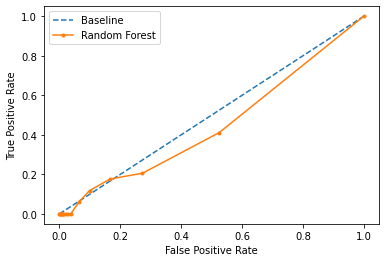

In [23]:
baseline = [0 for _ in range(len(y_test))]
baseline_auc = roc_auc_score(y_test, baseline)

baseline_fpr, baseline_tpr, _ = roc_curve(y_test, baseline)
rf_fpr, rf_tpr, _ = roc_curve(y_test, y_pred_proba)

pyplot.plot(baseline_fpr, baseline_tpr, linestyle='--', label='Baseline')
pyplot.plot(rf_fpr, rf_tpr, marker='.', label='Random Forest')

pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')

pyplot.legend()

pyplot.show()

## SMOTE

In [24]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

In [25]:
oversample = SMOTE(sampling_strategy=0.1)
X_train, y_train = oversample.fit_resample(X_train, y_train)

In [26]:
X_train.shape

(3247, 26)

In [27]:
y_train.value_counts()

0.0    2952
1.0     295
Name: outbreak, dtype: int64

In [28]:
rf = RandomForestClassifier(n_estimators=50, random_state=42)

In [29]:
%%time

rf.fit(X_train, y_train)

CPU times: user 441 ms, sys: 3.69 ms, total: 445 ms
Wall time: 444 ms


RandomForestClassifier(n_estimators=50, random_state=42)

In [30]:
y_pred = rf.predict(X_test)

In [31]:
print(confusion_matrix(y_test, y_pred))

[[1263    1]
 [  34    0]]


In [32]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.97      1.00      0.99      1264
         1.0       0.00      0.00      0.00        34

    accuracy                           0.97      1298
   macro avg       0.49      0.50      0.49      1298
weighted avg       0.95      0.97      0.96      1298



In [33]:
y_pred_proba = rf.predict_proba(X_test)[:, 1]

In [34]:
auc = roc_auc_score(y_test, y_pred_proba)

In [35]:
auc

0.5570783693224126

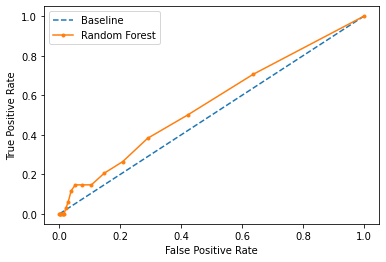

In [36]:
baseline = [0 for _ in range(len(y_test))]
baseline_auc = roc_auc_score(y_test, baseline)

baseline_fpr, baseline_tpr, _ = roc_curve(y_test, baseline)
rf_fpr, rf_tpr, _ = roc_curve(y_test, y_pred_proba)

pyplot.plot(baseline_fpr, baseline_tpr, linestyle='--', label='Baseline')
pyplot.plot(rf_fpr, rf_tpr, marker='.', label='Random Forest')

pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')

pyplot.legend()

pyplot.show()